In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/swiftai")' SwiftAI

Installing packages:
	.package(path: "/home/mlk/swift/swiftai")
		SwiftAI
With SwiftPM flags: []
Working in: /tmp/tmp03r_5j0v/swift-install
[1/2] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
[2/3] Merging module jupyterInstalledPackages
Initializing Swift...
Installation complete!


In [2]:
import SwiftAI
import TensorFlow
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")
import Foundation
import Just
import Path

In [ ]:
func loadCIFARFile(training: Bool,in directory: String = ".") -> (Tensor<Float>,Tensor<Int32>) {
    //downloadCIFAR10IfNotPresent(to: directory)
    // TODO: path & downloadable
    let imageCount = 10000 // per file, split into 5 files
    let imageByteSize = 3073    

    var bytes: [UInt8] = []
    var labels: [Int32] = []

    if training == true{
        let name = "data_batch_\(1).bin"
        let path = "\(directory)/cifar-10-batches-bin/\(name)"
        guard let fileContents = try? Data(contentsOf: URL(fileURLWithPath: path)) else {
            print("Could not read dataset file: \(name)")
            exit(-1)
        }
        guard fileContents.count == 30_730_000 else {
            print("Dataset file \(name) should have 30730000 bytes, instead had \(fileContents.count)")
            exit(-1)
        }
        for imageIndex in 0..<imageCount {

            let baseAddress = imageIndex * imageByteSize
            labels.append(Int32(fileContents[baseAddress]))
            bytes.append(contentsOf: fileContents[(baseAddress + 1)..<(baseAddress + 3073)])
        } 
        //for i in 1..<6{    
        //} 

    } else {
        let name = "test_batch.bin"
        let path = "\(directory)/cifar-10-batches-bin/\(name)"
        guard let fileContents = try? Data(contentsOf: URL(fileURLWithPath: path)) else {
            print("Could not read dataset file: \(name)")
            exit(-1)
        }
        guard fileContents.count == 30_730_000 else {
            print("Dataset file \(name) should have 30730000 bytes, instead had \(fileContents.count)")
            exit(-1)
        }
        for imageIndex in 0..<imageCount {

            let baseAddress = imageIndex * imageByteSize
            labels.append(Int32(fileContents[baseAddress]))
            bytes.append(contentsOf: fileContents[(baseAddress + 1)..<(baseAddress + 3073)])
        } 

    }
    let labelTensor = Tensor<Int32>(shape: [training ? imageCount : imageCount], scalars: labels)
    let images = Tensor<UInt8>(shape: [training ? imageCount : imageCount, 3, 32, 32], scalars: bytes)
    // Transpose from the CIFAR-provided N(CHW) to TF's default NHWC.
    let imageTensor = Tensor<Float>(images.transposed(permutation: [0, 2, 3, 1]))


    return (imageTensor, labelTensor)
}

func loadCIFARTrainingFiles(bs: Int = 64) -> DataBunch<DataBatch<TF, TI>>  {
    let (xTrain,yTrain) = loadCIFARFile(training: true)
    let (xValid,yValid)   = loadCIFARFile(training: false)
    return DataBunch(train: Dataset(elements: DataBatch(xb:xTrain, yb: yTrain)), 
                     valid: Dataset(elements: DataBatch(xb:xValid, yb: yValid)),
                     trainLen: xTrain.shape[0],
                     validLen: xValid.shape[0],
                     bs: bs)
}

let data_cifar = loadCIFARTrainingFiles()


In [5]:
public extension StringTensor { 
    func decodePng(channels: Int = 0) -> Tensor<UInt8> {
        return _Raw.decodePng(contents: self, channels: Int64(channels))
    }
}
public func openPng(fname: StringTensor) -> TF{
    let decodedImg = StringTensor(readFile: fname).decodePng(channels: 3) 
    let img = Tensor<Float>(decodedImg) / 255.0
    return img
}
let il = ItemList(fromFolder: Path.home/"swift/cifar10", extensions: ["png"])
let sd = SplitData(il) {grandParentSplitter(fName: $0, valid: "test")}
var procLabel = CategoryProcessor()
let sld = makeLabeledData(sd, fromFunc: parentLabeler, procLabel: &procLabel)
let rawData = sld.toDataBunch(itemToTensor: pathsToTensor, labelToTensor: intsToTensor, bs: 128) 
let data = transformData(rawData) { openPng(fname: $0) }


In [11]:
data_cifar.train.ds.first(where: { _ in true })!.xb.shape

: 

In [10]:
let d = mnistDataBunch(path: Path.home/"swift", flat: false, bs: 256)

: 

<Figure size 432x288 with 0 Axes>

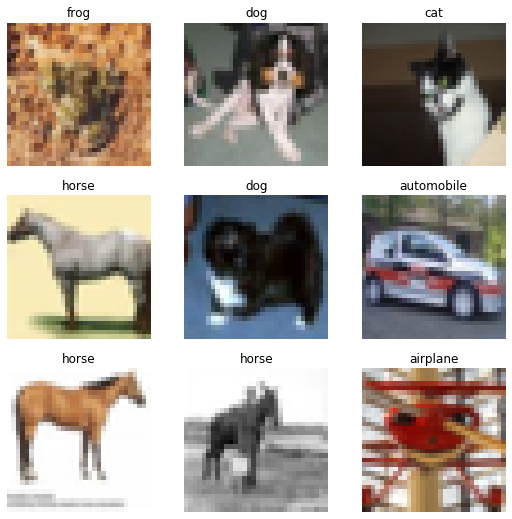

In [6]:
plt.figure()
let batch = data.train.oneBatch()!
let labels = batch.yb.scalars.map { procLabel.vocab![Int($0)] }
showImages(batch.xb, labels: labels)


In [ ]:
//MLP model with 2 hidden layers
public struct MyModel: Layer {
    public var Conv1:    ConvBN<Float>
    public var Conv2:    ConvBN<Float>
    public var Conv3:    ConvBN<Float>    
    public var pool =    MaxPool2D<Float>(poolSize: (2, 2), strides: (2,2))
    public var gpool =   FAGlobalAvgPool2D<Float>()
    public var flatten:  Flatten<Float>
    public var bn:       BatchNorm<Float>
    public var dropout = Dropout<Float>(probability: 0.5)
    public var fc1:      FADense<Float>
    public var fc2:      FADense<Float>
    public var out:      FADense<Float>

    
    public init(cIn: Int, nOut: Int, filterIn: [Int]){
        Conv1   = ConvBN(cIn, filterIn[0], ks: 5, stride: 1)
        Conv2   = ConvBN(filterIn[0], filterIn[1], ks: 5, stride: 1)
        Conv3   = ConvBN(filterIn[1], filterIn[2], ks: 5, stride: 1)
        flatten = Flatten()
        fc1     = FADense(filterIn.last!, 512, activation: relu)
        bn      = BatchNorm(featureCount: 512)
        fc2     = FADense(512, 512, activation: relu)
        out     = FADense(512, nOut)
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        let C = input.compose(Conv1, pool, Conv2, pool, Conv3, gpool)
        let h1 = C.compose(flatten,fc1, bn, dropout)
        let h2 = h1.compose(fc2, bn, dropout, out)
        return h2
        //return out(bn(hidden2(bn(hidden1(flatten(pool(Conv3(pool(Conv2(pool(Conv1(input))))))))))))
        //return input.compose(Conv1,pool,Conv2,pool,flatten,hidden1,bn,hidden2,bn,out)
    }
}


In [ ]:
func modelInit() -> MyModel { return MyModel(cIn: 3, nOut: 10, filterIn: [64,128,256]) }

In [ ]:
let mean = Tensor<Float>([0.485, 0.456, 0.406])
let std = Tensor<Float>([0.229, 0.224, 0.225])
let optFunc: (MyModel) -> StatefulOptimizer<MyModel> = adamOpt(lr: 1e-3, mom: 0.9, beta: 0.99, wd: 1e-2, eps: 1e-6)
let learner = Learner(data: data_cifar, lossFunc: crossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegate(learner.makeNormalize(mean: mean, std: std))

In [ ]:
modelInit()

In [ ]:
let LR_rec = learner.lrFind()

In [ ]:
LR_rec.plotLRFinder()

In [ ]:
var procLabel = CategoryProcessor()
let batch = data_cifar.train.oneBatch()!
showImages(batch.xb)

: 

In [ ]:
learner.addOneCycleDelegates(1e-3, pctStart: 0.3)
try learner.fit(10)

In [ ]:
let y = Array(0..<recorder_nest_l2.losses.count)
let sgd: Array<Float>     = recorder_sgd.losses.compactMap{$0.scalar}
let nest: Array<Float>    = recorder_nest.losses.compactMap{$0.scalar}
let nest_l1: Array<Float> = recorder_nest_l1.losses.compactMap{$0.scalar}
let nest_l2: Array<Float> = recorder_nest_l2.losses.compactMap{$0.scalar}


In [ ]:
func smooth_curve(points:Array<Float>, factor:Float=0.9) -> Array<Float> {
    var smoothed_points: Array<Float> = Array()
    let x1 = points.first
    smoothed_points.append(x1!)
    var points_ = points.dropFirst()
    for point in points_{
            let previous = smoothed_points.last
            let smth = previous! * factor + point * (1 - factor)
            smoothed_points.append(smth)
    }
        
    return smoothed_points
}
    

In [ ]:
plt.figure(figsize: [15, 10])
let i = 0
let n = 5000
let y2 = Array(y[i..<n])
plt.plot(y2,smooth_curve(points: Array(sgd[i..<n])), label:"SGD")
plt.plot(y2,smooth_curve(points: Array(nest[i..<n])), label:"SGD Nesterov, m=0.9")
plt.plot(y2,smooth_curve(points: Array(nest_l1[i..<n])), label:"SGD Nesterov, m=0.9, L1")
plt.plot(y2,smooth_curve(points: Array(nest_l2[i..<n])), label:"SGD Nesterov, m=0.9, L2")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("MLP 512-512 MNIST")
plt.show()